In [2]:
pip install tensorflow


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Load dataset properly
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Create batches
buffer_size = 60000
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [8]:
import time

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        print(f'Time for epoch {epoch+1} is {time.time()-start:.2f} sec')


In [9]:
epochs = 50
train(train_dataset, epochs)


Time for epoch 1 is 19.26 sec
Time for epoch 2 is 10.93 sec
Time for epoch 3 is 11.00 sec
Time for epoch 4 is 11.07 sec
Time for epoch 5 is 11.14 sec
Time for epoch 6 is 11.20 sec
Time for epoch 7 is 11.29 sec
Time for epoch 8 is 11.38 sec
Time for epoch 9 is 11.47 sec
Time for epoch 10 is 11.53 sec
Time for epoch 11 is 11.57 sec
Time for epoch 12 is 11.60 sec
Time for epoch 13 is 11.63 sec
Time for epoch 14 is 11.65 sec
Time for epoch 15 is 11.68 sec
Time for epoch 16 is 11.70 sec
Time for epoch 17 is 11.73 sec
Time for epoch 18 is 11.79 sec
Time for epoch 19 is 11.83 sec
Time for epoch 20 is 11.88 sec
Time for epoch 21 is 11.87 sec
Time for epoch 22 is 11.87 sec
Time for epoch 23 is 11.87 sec
Time for epoch 24 is 11.88 sec
Time for epoch 25 is 12.03 sec
Time for epoch 26 is 12.05 sec
Time for epoch 27 is 12.03 sec
Time for epoch 28 is 12.03 sec
Time for epoch 29 is 11.97 sec
Time for epoch 30 is 11.94 sec
Time for epoch 31 is 12.00 sec
Time for epoch 32 is 20.46 sec
Time for epoch 33

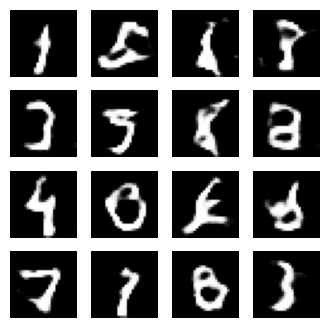

In [10]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

seed = tf.random.normal([16, 100])
generate_and_save_images(generator, 0, seed)
